### Βήμα 3: Classification δεδομένων

#### Βιβλιοθήκες

In [170]:
from operator import index

import numpy as np
import pandas as pd
import seaborn as sns
from keras.src.saving.legacy.saved_model.load import metrics
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, RocCurveDisplay
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

#### Φόρτωση δεδομένων

In [171]:
bank_data = pd.read_csv('../data_preprocessing/clean_data.csv')
# Get rid of unwanted extra column
bank_data.drop('Unnamed: 0', axis=1, inplace=True)

### 1ος Ταξινομητής: Bayesian

#### Encoding κατηγορικών χαρακτηριστικών

In [172]:
le = LabelEncoder()
categorical_columns = ['job','marital','education','default','housing','loan','month','y']

for column in categorical_columns:
    bank_data[column] = le.fit_transform(bank_data[column])

#### Διαχωρισμός εξαρτημένων(y) και ανεξάρτηων μεταβλητών

In [173]:
X = bank_data.iloc[:,:-1].values
y = bank_data.iloc[:,-1].values

#### Split

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=True, stratify=y)

#### Κανονικοποίηση

In [175]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Εκπαίδευση του Bayesian ταξινομητή

In [176]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

In [177]:
y_prediction = classifier.predict(X_test)
print(np.concatenate((y_prediction.reshape(len(y_prediction), 1), y_test.reshape(len(y_test), 1)), 1))

[[0 0]
 [1 0]
 [0 0]
 ...
 [0 1]
 [0 0]
 [0 0]]


### Αξιολόγηση ταξινομητή

#### Accuracy Score

In [178]:
accuracy_score(y_test, y_prediction)

0.8787628012827143

#### Classification Report

In [179]:
print(f'Classification Report: \n{classification_report(y_test, y_prediction)}')

Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      8821
           1       0.32      0.35      0.33       846

    accuracy                           0.88      9667
   macro avg       0.63      0.64      0.63      9667
weighted avg       0.88      0.88      0.88      9667



#### Confusion Matrix

<Axes: >

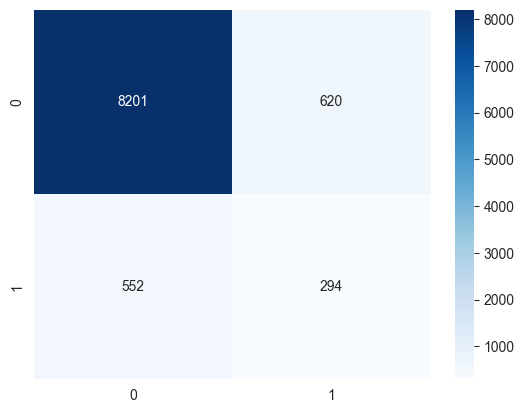

In [180]:
cf_matrix = confusion_matrix(y_test, y_prediction)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True)

#### AUC/ROC curve

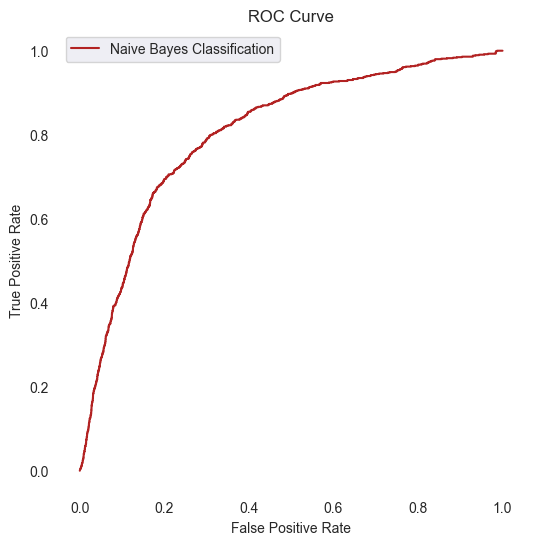

In [181]:
# Plot AUC/ROC curve
y_pred_proba = classifier.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,  y_pred_proba)

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(fpr, tpr, label='Naive Bayes Classification', color = 'firebrick')
ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.box(False)
ax.legend();

### 2ος Ταξινομητής: XGBoost

#### Φόρτωση δεδομένων

In [182]:
xgb_bank_data = pd.read_csv('../data_preprocessing/clean_data.csv')
# Get rid of unwanted column
xgb_bank_data.drop('Unnamed: 0', axis=1, inplace=True)

#### Encoding κατηγορικών χαρακτηριστικών

In [183]:
oe = OrdinalEncoder()

for column in categorical_columns:
    xgb_bank_data[column] = oe.fit_transform(xgb_bank_data[[column]])

#### Διαχωρισμός ανεξάρτητων και εξαρτημένων μεταβλητών, split

In [184]:
X_xgb= bank_data.iloc[:,:-1].values
y_xgb = bank_data.iloc[:,-1].values
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42, stratify=y_xgb)


#### Κανονικοποίηση αριθμητικών χαρακτηριστικών


In [185]:
X_train_xgb = scaler.fit_transform(X_train_xgb)
X_test_xgb = scaler.transform(X_test_xgb)

#### Εκπαίδευση του ταξινομητή

In [186]:
xgboost_classifier = XGBClassifier(n_estimators=25,n_jobs=-1)
xgboost_classifier.fit(X_train_xgb, y_train_xgb, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=25, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

### Αξιολόγηση του ταξινομητή

In [187]:
xgboost_classifier.score(X_test_xgb, y_test_xgb)

0.9257822601499871

#### Confusion matrix

Text(50.722222222222214, 0.5, 'True Label')

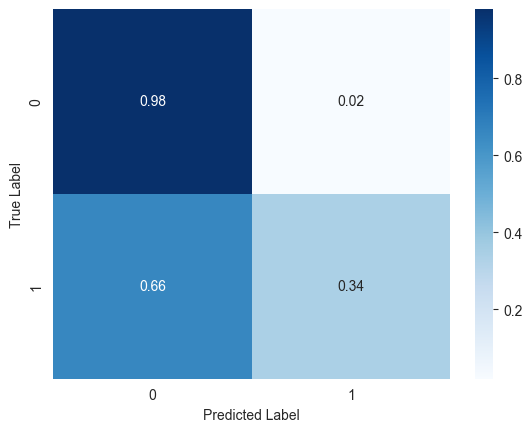

In [188]:
ax = sns.heatmap (
    confusion_matrix(y_test_xgb, xgboost_classifier.predict(X_test_xgb), normalize='true').round(2),
    annot=True, cmap='Blues'
)

ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

#### Classification report

In [189]:
print(classification_report(y_test_xgb, xgboost_classifier.predict(X_test_xgb)))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      7057
           1       0.64      0.34      0.45       677

    accuracy                           0.93      7734
   macro avg       0.79      0.66      0.70      7734
weighted avg       0.91      0.93      0.92      7734



#### AUC/ROC curve

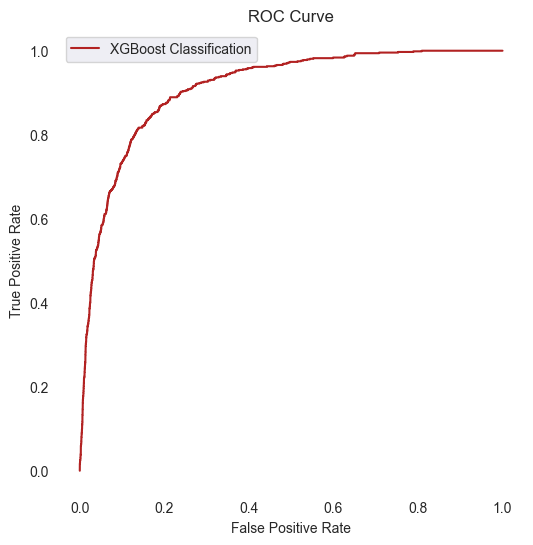

In [190]:
# Plot AUC/ROC curve
y_pred_proba_xgb = xgboost_classifier.predict_proba(X_test_xgb)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test_xgb,  y_pred_proba_xgb)

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(fpr, tpr, label='XGBoost Classification', color = 'firebrick')
ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.box(False)
ax.legend();

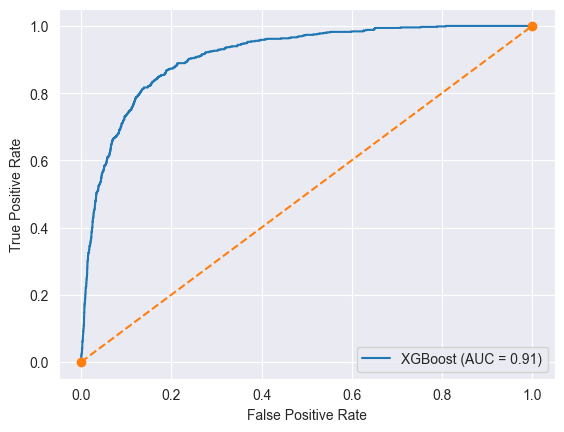

In [191]:
fpr, tpr, thresholds = roc_curve(y_test_xgb, y_pred_proba_xgb)
roc_auc = metrics.auc(fpr, tpr)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='XGBoost')
display.plot()

plt.plot([0, 1], [0, 1], 'o--')
plt.show()

#### Ο XGBoost ταξινομητής έχει καλύτερο accuracy score από τον Bayesian και όπως φαίνεται από το ROC curve, η καμπύλη του "γέρνει" πιο κοντά στο 1, δηλαδή μεγαλύτερο True Positive Rate.

### Νευρωνικά δίκτυα με tensorflow/keras

### Model1 - Standard Training

#### Θα χρησιμποιηθούν τα dataframes X,y όπως μετασχηματίστηκαν για τον Bayesian ταξινομητή

In [217]:
X_train_nw, X_test_nw, y_train_nw, y_test_nw = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_nw = scaler.fit_transform(X_train_nw)
X_test_nw = scaler.transform(X_test_nw)

In [218]:
model1 = Sequential([
    Input(shape=(X_train_nw.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [219]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [230]:
model1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 64)                896       
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dense_26 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3009 (11.75 KB)
Trainable params: 3009 (11.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [221]:
history = model1.fit(X_train_nw, y_train_nw, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
774/774 [==============================] - 1s 1ms/step - loss: 0.2427 - accuracy: 0.9143 - val_loss: 0.2311 - val_accuracy: 0.9130
Epoch 2/50
774/774 [==============================] - 1s 867us/step - loss: 0.2178 - accuracy: 0.9172 - val_loss: 0.2239 - val_accuracy: 0.9148
Epoch 3/50
774/774 [==============================] - 1s 936us/step - loss: 0.2130 - accuracy: 0.9178 - val_loss: 0.2230 - val_accuracy: 0.9142
Epoch 4/50
774/774 [==============================] - 1s 928us/step - loss: 0.2104 - accuracy: 0.9201 - val_loss: 0.2227 - val_accuracy: 0.9148
Epoch 5/50
774/774 [==============================] - 1s 895us/step - loss: 0.2083 - accuracy: 0.9196 - val_loss: 0.2206 - val_accuracy: 0.9158
Epoch 6/50
774/774 [==============================] - 1s 883us/step - loss: 0.2063 - accuracy: 0.9199 - val_loss: 0.2233 - val_accuracy: 0.9137
Epoch 7/50
774/774 [==============================] - 1s 888us/step - loss: 0.2051 - accuracy: 0.9199 - val_loss: 0.2177 - val_accuracy: 0

In [222]:
loss, accuracy = model1.evaluate(X_test_nw, y_test_nw)
print(f'Standard Model Accuracy: {accuracy}')

242/242 [==============================] - 0s 623us/step - loss: 0.2317 - accuracy: 0.9092
Standard Model Accuracy: 0.909231960773468


In [223]:
predictions = model1.predict(X_test_nw)
predicted_y = np.argmax(predictions, axis=1)
accuracy = np.mean(predicted_y == y_test_nw)
print(f'Accuracy on test set: {accuracy}')

242/242 [==============================] - 0s 535us/step
Accuracy on test set: 0.9124644427204551


In [224]:
print(classification_report(y_test_nw, predicted_y, zero_division=1))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      7057
           1       1.00      0.00      0.00       677

    accuracy                           0.91      7734
   macro avg       0.96      0.50      0.48      7734
weighted avg       0.92      0.91      0.87      7734



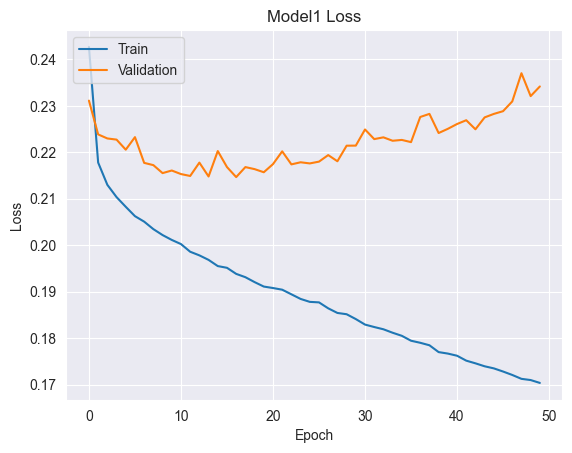

In [262]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model1 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

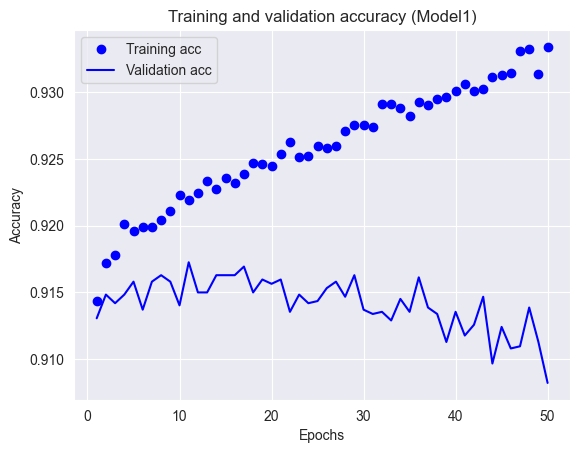

In [265]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (Model1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Model2 - Transfer Learning

In [247]:
X_pretrain_nw, X_finetune_nw, y_pretrain_nw, y_finetune_nw = train_test_split(X_train_nw, y_train_nw, test_size=0.5, random_state=42)

In [248]:
pretrain_model2 = Sequential([
    Input(shape=(X_pretrain_nw.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [249]:
pretrain_model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [250]:
pretrain_history = pretrain_model2.fit(X_pretrain_nw, y_pretrain_nw, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
387/387 [==============================] - 1s 1ms/step - loss: 0.2676 - accuracy: 0.9069 - val_loss: 0.2339 - val_accuracy: 0.9118
Epoch 2/50
387/387 [==============================] - 0s 983us/step - loss: 0.2235 - accuracy: 0.9151 - val_loss: 0.2318 - val_accuracy: 0.9082
Epoch 3/50
387/387 [==============================] - 0s 967us/step - loss: 0.2185 - accuracy: 0.9176 - val_loss: 0.2259 - val_accuracy: 0.9105
Epoch 4/50
387/387 [==============================] - 0s 913us/step - loss: 0.2146 - accuracy: 0.9180 - val_loss: 0.2263 - val_accuracy: 0.9131
Epoch 5/50
387/387 [==============================] - 0s 924us/step - loss: 0.2110 - accuracy: 0.9175 - val_loss: 0.2280 - val_accuracy: 0.9114
Epoch 6/50
387/387 [==============================] - 0s 910us/step - loss: 0.2090 - accuracy: 0.9188 - val_loss: 0.2260 - val_accuracy: 0.9111
Epoch 7/50
387/387 [==============================] - 0s 913us/step - loss: 0.2068 - accuracy: 0.9208 - val_loss: 0.2235 - val_accuracy: 0

In [251]:
pretrained_model2_weights = pretrain_model2.get_weights()

In [252]:
finetune_model2 = Sequential([
    Input(shape=(X_pretrain_nw.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [253]:
finetune_model2.set_weights(pretrained_model2_weights)

In [254]:
finetune_model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [255]:
finetune_history = finetune_model2.fit(X_finetune_nw, y_finetune_nw, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
387/387 [==============================] - 1s 1ms/step - loss: 0.2306 - accuracy: 0.9112 - val_loss: 0.2353 - val_accuracy: 0.9082
Epoch 2/50
387/387 [==============================] - 0s 938us/step - loss: 0.2129 - accuracy: 0.9176 - val_loss: 0.2310 - val_accuracy: 0.9114
Epoch 3/50
387/387 [==============================] - 0s 924us/step - loss: 0.2062 - accuracy: 0.9182 - val_loss: 0.2300 - val_accuracy: 0.9118
Epoch 4/50
387/387 [==============================] - 0s 923us/step - loss: 0.2012 - accuracy: 0.9220 - val_loss: 0.2299 - val_accuracy: 0.9105
Epoch 5/50
387/387 [==============================] - 0s 924us/step - loss: 0.1972 - accuracy: 0.9238 - val_loss: 0.2277 - val_accuracy: 0.9101
Epoch 6/50
387/387 [==============================] - 0s 923us/step - loss: 0.1946 - accuracy: 0.9236 - val_loss: 0.2298 - val_accuracy: 0.9105
Epoch 7/50
387/387 [==============================] - 0s 923us/step - loss: 0.1920 - accuracy: 0.9251 - val_loss: 0.2315 - val_accuracy: 0

In [257]:
loss, accuracy = finetune_model2.evaluate(X_test_nw, y_test_nw)
print(f'Transfer Learning Model Accuracy: {accuracy}')

242/242 [==============================] - 0s 642us/step - loss: 0.2526 - accuracy: 0.9132
Transfer Learning Model Accuracy: 0.9132402539253235


In [258]:
predictions2 = finetune_model2.predict(X_test_nw)
predicted_y2 = np.argmax(predictions2, axis=1)
accuracy = np.mean(predicted_y2 == y_test_nw)
print(f'Accuracy on test set: {accuracy}')

242/242 [==============================] - 0s 561us/step
Accuracy on test set: 0.9124644427204551


In [259]:
print(classification_report(y_test_nw, predicted_y2, zero_division=1))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      7057
           1       1.00      0.00      0.00       677

    accuracy                           0.91      7734
   macro avg       0.96      0.50      0.48      7734
weighted avg       0.92      0.91      0.87      7734



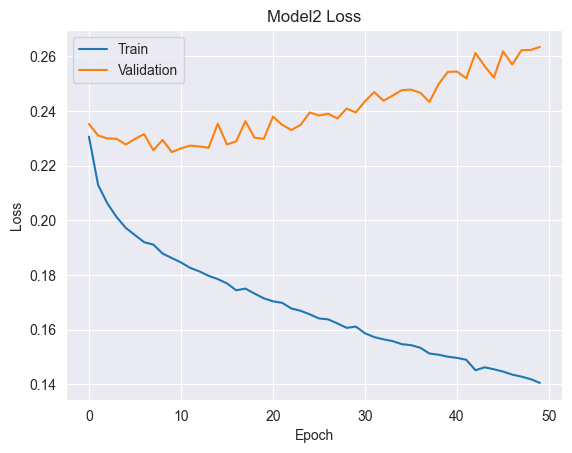

In [261]:
plt.plot(finetune_history.history['loss'])
plt.plot(finetune_history.history['val_loss'])
plt.title('Model2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

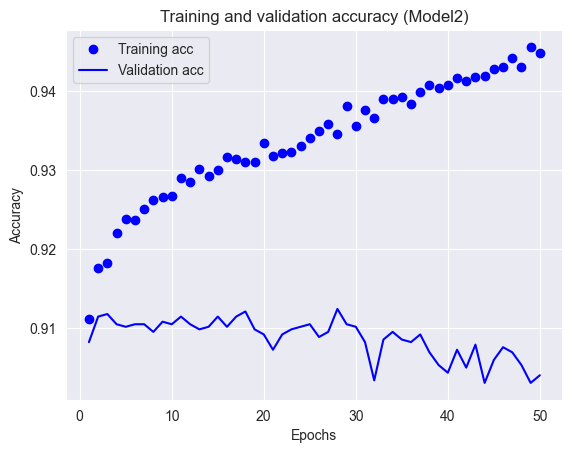

In [264]:
acc = finetune_history.history['accuracy']
val_acc = finetune_history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (Model2)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()